[View in Colaboratory](https://colab.research.google.com/github/rr-y/facial-expression-recognition/blob/master/cnn_model.ipynb)

In [0]:
import time
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix
%matplotlib inline


In [7]:
 # Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .


Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setti

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [9]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force

Enter verification code: ··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [10]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/Colab\ Notebooks


Files in Drive:
exp.ipynb  fer2013.csv	Untitled0.ipynb  Untitled3-2.ipynb  Untitled.ipynb


##### Hyper parameter

In [0]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 1

# image dimensions (only squares for now)
img_size = 48

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = [0,1,2,3,4,5,6]
num_classes = len(classes)

# batch size
batch_size = 400

# validation split
validation_size = .30

No_of_batches = 60

epoch = 500




##### Data Preprocessing

In [0]:
df = pd.read_csv("drive/Colab Notebooks/fer2013.csv")

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['pixels'], df['emotion'], test_size=0.3, random_state=30)
df_train=pd.DataFrame({'index':X_train.index, 'value':X_train.values})
df_test=pd.DataFrame({'index':X_test.index, 'value':X_test.values})
X_train=df_train['value']
X_test=df_test['value']


images=[]

for i in range(len(X_train)):
    image_string = X_train[i]
    image = [int(x) for x in image_string.split()]
    image=np.array(image,dtype='float32')
    image=image.reshape((48,48,1))
    images.append(image)

    
    
images_test=[]

for i in range(len(X_test)):
    image_string = X_test[i]
    image = [int(x) for x in image_string.split()]
    image=np.array(image,dtype='float32')
    image=image.reshape((48,48,1))
    images_test.append(image)

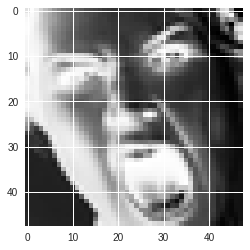

In [14]:
plt.imshow(images_test[2].reshape((48,48)))
plt.show()

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [16]:
y_train_hot=convert_to_one_hot(y_train,7)
y_test_hot=convert_to_one_hot(y_test,7)
images=np.array(images,dtype = "float32")
images_test=np.array(images_test ,dtype = "float32")
images_test.reshape((10767,2304))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


array([[232., 231., 228., ...,  79.,  79.,  84.],
       [134., 134., 128., ...,  30.,  30.,  30.],
       [ 52.,   4.,  34., ..., 233., 244., 231.],
       ...,
       [ 42.,  31.,  81., ..., 255., 255., 255.],
       [ 80.,  81.,  77., ...,  84.,  75.,  70.],
       [243., 242., 240., ..., 200., 205., 204.]], dtype=float32)

In [0]:
images_test = images_test.reshape((10767,2304))
images_train = images.reshape(25120,2304)

In [18]:
y_train_hot.shape

(25120, 7)

In [19]:
images_train.shape

(25120, 2304)

In [20]:
type(images_train)

numpy.ndarray

In [21]:
y_test_hot.shape

(10767, 7)

## Tensorflow graph

#####  Helper-functions for creating new variables¶


In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


In [0]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

##### Helper-function for creating a new Convolutional Layer

In [0]:
def new_conv_layer(input,num_input_channels,filter_size,num_filters,use_pooling=True):

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    
    layer = tf.nn.conv2d(input=input, filter=weights,strides=[1, 1, 1, 1],padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    return layer, weights


In [0]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


##### Helper-function for creating a new Fully-Connected Layer¶

In [0]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')


In [0]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])



##### Convolutional Layer 1

In [0]:
layer_1 , weight1 =  new_conv_layer(input = x_image ,num_input_channels = 1 ,filter_size = filter_size1,num_filters = num_filters1,use_pooling=True)

In [30]:
layer_1.shape

TensorShape([Dimension(None), Dimension(24), Dimension(24), Dimension(32)])

In [31]:
weight1.shape

TensorShape([Dimension(3), Dimension(3), Dimension(1), Dimension(32)])

In [0]:
##### Convolutional Layer 2

Convolutional Layer 2

In [0]:
layer_2 , weight2 =  new_conv_layer(input = layer_1 ,num_input_channels = num_filters1 ,filter_size = filter_size2,num_filters = num_filters2,use_pooling=True)

In [34]:
layer_2.shape

TensorShape([Dimension(None), Dimension(12), Dimension(12), Dimension(32)])

In [35]:
weight2.shape

TensorShape([Dimension(3), Dimension(3), Dimension(32), Dimension(32)])

Convolutional Layer 3

In [0]:
layer_3 , weight3 =  new_conv_layer(input = layer_2 ,num_input_channels = num_filters2 ,filter_size = filter_size3,num_filters = num_filters3,use_pooling=True)

In [37]:
layer_3.shape
weight3.shape

TensorShape([Dimension(3), Dimension(3), Dimension(32), Dimension(64)])

Flaten

In [0]:
flaten_layer , no_features =  flatten_layer(layer_3)

In [39]:
no_features

2304

**Fully Connected layer 1**

In [0]:
layer_fc1 =  new_fc_layer(input = flaten_layer,          # The previous layer.
                 num_inputs = no_features,     # Num. inputs from prev. layer.
                 num_outputs = fc_size,    # Num. outputs.
                 use_relu=True)

In [41]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

**Fully Connected layer 2**

In [0]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [43]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 7) dtype=float32>

In [44]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
cost = tf.reduce_mean(cross_entropy)

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)



**Performance Measure**

In [0]:
# y_true_cls = tf.argmax(y_true, axis=1)
y_pred = tf.nn.softmax(layer_fc2)
# y_pred_cls = tf.argmax(y_pred, dimension=1)
# correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


**Tensorflow Session**

In [0]:

train_batch_size  = batch_size

In [0]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))


In [84]:
from sklearn.metrics import confusion_matrix

with tf.Session() as sess:
  print("Start")
  sess.run(tf.initialize_all_variables())
  
  for j in range(1,epoch):
    
    for i in range(1,No_of_batches): 
      sess.run(optimizer,feed_dict = {x : images_train[i*batch_size:(i+1)*batch_size] , y_true : y_train_hot[i*batch_size:(i+1)*batch_size]})
     
    if j%10 == 0:
          print("on step {}".format(j))
          print("accuracy")
          matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
          acc = tf.reduce_mean(tf.cast(matches,tf.float32 ))
          print(sess.run(acc,feed_dict = {x : images_test, y_true : y_test_hot}))
#           print(sess.run(tf.confusion_matrix(labels=y_true[:24000], predictions=y_pred[:24000], num_classes=classes)))
#     print(sess.run(tf.confusion_matrix(tf.argmax(y_true,1),(tf.argmax(y_pred,1)))))
     

                                      
                                      
                                                                                                                                                                                                                                                                                                      

Start
on step 10
accuracy
0.40754157
on step 20
accuracy
0.45193648
on step 30
accuracy
0.46410328
on step 40
accuracy
0.48425746
on step 50
accuracy
0.48360732
on step 60
accuracy
0.4848147
on step 70
accuracy
0.48862264
on step 80
accuracy
0.48815826
on step 90
accuracy
0.48425746
on step 100
accuracy
0.47543418
on step 110
accuracy
0.47459832
on step 120
accuracy
0.46215287
on step 130
accuracy
0.4797994
on step 140
accuracy
0.47014025
on step 150
accuracy
0.46317452
on step 160
accuracy
0.46865422
on step 170
accuracy
0.47682735
on step 180
accuracy
0.47952077
on step 190
accuracy
0.47543418
on step 200
accuracy
0.4758986
on step 210
accuracy
0.4660537
on step 220
accuracy
0.47041887
on step 230
accuracy
0.4518436
on step 240
accuracy
0.46233863
on step 250
accuracy
0.47952077
on step 260
accuracy
0.47942787
on step 270
accuracy
0.46846846
on step 280
accuracy
0.47515556
on step 290
accuracy
0.45230797
on step 300
accuracy
0.4750627
on step 310
accuracy
0.47431967
on step 320
accur

In [0]:
from sklearn.metrics import confusion_matrix

In [66]:
print(confusion_matrix(y_pred,y_true))

ValueError: ignored

In [71]:
y_pred.shape

TensorShape([Dimension(None), Dimension(7)])

In [73]:
y_pred.shape

TensorShape([Dimension(None), Dimension(7)])

In [75]:
y_true[:128].shape

TensorShape([Dimension(None), Dimension(7)])